<a href="https://colab.research.google.com/github/Prisze/AAI-510-Final-Project/blob/main/AAI510.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tab-transformer-pytorch

In [ ]:
import pandas as pd

# Load datasets

PATH_TRAIN = 'customer_churn_dataset-training-master.csv'
PATH_TEST = 'customer_churn_dataset-testing-master.csv'

df_train = pd.read_csv(PATH_TRAIN).dropna()
df_test = pd.read_csv(PATH_TEST).dropna()

In [ ]:
from pandas.api.types import CategoricalDtype
import torch
import json

# Drop customer ID
column_customerid = 'CustomerID'
df_train = df_train.drop(columns=[column_customerid]).copy()
df_test  = df_test.drop(columns=[column_customerid]).copy()

# Get categorical and numerical columns
cat_cols = df_train.select_dtypes(include=['object']).columns
num_cols = df_train.select_dtypes(exclude=['object']).columns

# Build category to integer mappings
cat_dtypes = {}
for column in cat_cols:
    df_train[column] = df_train[column].astype('category')
    cats = df_train[column].cat.categories
    cat_dtypes[column] = CategoricalDtype(categories=cats, ordered=False)

    # Replace categories with integers
    df_train[column] = df_train[column].cat.codes

# Apply those same mappings to test
for column in cat_cols:
    df_test[column] = df_test[column].astype(cat_dtypes[column]).cat.codes

# Calculate continuous variables mean and std for normalization
cont_stats = df_train[num_cols].agg(['mean', 'std'])
continuous_mean_std = torch.tensor(cont_stats.values.T, dtype=torch.float32)

# Calculate category cardinalities, ensuring the column is preserved
cardinalities = [len(cat_dtypes[column].categories) for column in cat_cols]

# Save config for deployment
with open('config.json', 'w') as f:
  json.dump({
    'cat_cols': cat_cols.tolist(),
    'num_cols': num_cols.tolist(),
    'cardinalities': cardinalities,
    'continuous_mean_std': continuous_mean_std.tolist(),
    'cat_dtypes': {
        column: cat_dtypes[column].categories.tolist()
        for column in cat_cols
    }
  }, f)

In [ ]:
from torch.utils.data import Dataset
import numpy as np

# Wrapper Dataset class
class ChurnDataset(Dataset):
  def __init__(self, df: pd.DataFrame):
    self.x_categ = df[cat_cols].values.astype(np.int64)
    self.x_cont = df[num_cols].values.astype(np.float32)
    self.y = df['Churn'].values.astype(np.float32)

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return (
      torch.from_numpy(self.x_categ[idx]),
      torch.from_numpy(self.x_cont[idx]),
      torch.tensor(self.y[idx]),
    )

In [ ]:
from torch.utils.data import DataLoader

# Prepare Data Loaders
BATCH_SIZE = 512

train_loader = DataLoader(ChurnDataset(df_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(ChurnDataset(df_test), batch_size=BATCH_SIZE)

In [ ]:
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss
from tab_transformer_pytorch import TabTransformer

# Build model and training objects
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = TabTransformer(
  categories=tuple(cardinalities),
  num_continuous=len(num_cols),
  dim=32,
  dim_out=1,
  depth=6,
  heads=8,
  attn_dropout=0.1,
  ff_dropout=0.1,
  mlp_hidden_mults=(4, 2),
  continuous_mean_std=continuous_mean_std,
).to(device)

criterion = BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

In [ ]:
from tqdm import tqdm

# Define train/test iteration
def run_epoch(loader, train: bool = False):
  """Run one epoch; returns (avg_loss, preds, labels)."""

  model.train() if train else model.eval()
  total_loss, preds, labels = 0.0, [], []

  # Wrap loader in tqdm for progress reporting
  desc = 'Train' if train else 'Test'
  for x_cat, x_cont, y in tqdm(loader, desc=f'{desc} Epoch', unit='batch'):
    x_cat, x_cont, y = (
      x_cat.to(device),
      x_cont.to(device),
      y.to(device).unsqueeze(1),
    )

    with torch.set_grad_enabled(train):
      logits = model(x_cat, x_cont)
      loss = criterion(logits, y)

      if train:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_loss += loss.item() * y.size(0)
    preds.append(torch.sigmoid(logits.detach()).cpu())
    labels.append(y.cpu())

  preds = torch.cat(preds).numpy().ravel()
  labels = torch.cat(labels).numpy().ravel()

  return total_loss / len(loader.dataset), preds, labels


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Train model
EPOCHS = 7

best_auc, best_state = 0, None
train_loss_history, test_loss_history = [], []
for epoch in range(1, EPOCHS + 1):
  train_loss, _, _ = run_epoch(train_loader, train=True)
  test_loss, test_preds, test_labels = run_epoch(test_loader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  test_auc = roc_auc_score(test_labels, test_preds)
  test_acc = accuracy_score(test_labels, test_preds >= 0.5)

  print(
    f'Epoch {epoch:02d} | train_loss={train_loss:.4f} | test_loss={test_loss:.4f} | test_auc={test_auc:.4f} | test_acc={test_acc:.4f}'
  )

  if test_auc > best_auc:
    print('Updated best model')
    best_auc = test_auc
    best_state = model.state_dict()
    torch.save(best_state, 'tabtransformer_best.tb')

Test Epoch: 100%|██████████| 126/126 [00:02<00:00, 47.29batch/s]


Epoch 01 | train_loss=0.0264 | test_loss=1.5608 | test_auc=0.9712 | test_acc=0.7659
Updated best model


Test Epoch: 100%|██████████| 126/126 [00:02<00:00, 47.50batch/s]


Epoch 02 | train_loss=0.0043 | test_loss=2.2923 | test_auc=0.9319 | test_acc=0.7504


Test Epoch: 100%|██████████| 126/126 [00:02<00:00, 47.65batch/s]


Epoch 03 | train_loss=0.0033 | test_loss=2.2440 | test_auc=0.9346 | test_acc=0.7475


Test Epoch: 100%|██████████| 126/126 [00:02<00:00, 48.05batch/s]


Epoch 04 | train_loss=0.0028 | test_loss=3.6624 | test_auc=0.8854 | test_acc=0.7094


Test Epoch: 100%|██████████| 126/126 [00:02<00:00, 45.04batch/s]


Epoch 05 | train_loss=0.0025 | test_loss=5.4171 | test_auc=0.8342 | test_acc=0.6937


Test Epoch: 100%|██████████| 126/126 [00:02<00:00, 47.85batch/s]


Epoch 06 | train_loss=0.0022 | test_loss=28.3146 | test_auc=0.8114 | test_acc=0.6957


Test Epoch: 100%|██████████| 126/126 [00:02<00:00, 44.83batch/s]

Epoch 07 | train_loss=0.0023 | test_loss=10.3803 | test_auc=0.8164 | test_acc=0.7371


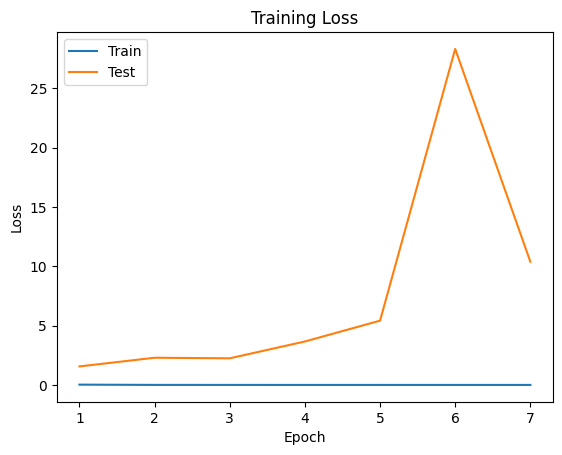

In [ ]:
from matplotlib import pyplot as plt

# Plot training loss

epochs = range(1, len(train_loss_history) + 1)

plt.plot(epochs, train_loss_history, label='Train')
plt.plot(epochs, test_loss_history,  label='Test')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
  f1_score, roc_auc_score)

# Evaluate best model
best_state = torch.load('tabtransformer_best.tb', map_location=torch.device(device))
model.load_state_dict(best_state)
_, test_preds, test_labels = run_epoch(test_loader)
pred_labels = (test_preds >= 0.5).astype(int)

print('')
print(f'accuracy score: {accuracy_score(test_labels, pred_labels)}')
print(f'precision score: {precision_score(test_labels, pred_labels)}')
print(f'recall score: {recall_score(test_labels, pred_labels)}')
print(f'f1 score: {f1_score(test_labels, pred_labels)}')
print(f'roc auc score: {roc_auc_score(test_labels, test_preds)}')

Test Epoch: 100%|██████████| 126/126 [00:04<00:00, 28.70batch/s]



accuracy score: 0.7659303445490415
precision score: 0.6703253020030476
recall score: 0.9954087823434886
f1 score: 0.8011455116530736
roc auc score: 0.9712085250278145
